# Notebook to Compare SWE DataSources 

# Step 0 - Set Up Notebook

In [28]:
# import libraries 
import pandas as pd
import geopandas as gpd
import fsspec
import warnings
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from snowML.datapipe.utils import get_geos as gg
from snowML.datapipe.utils import get_dem as dm
from snowML.datapipe.utils import data_utils as du


In [2]:
# define constants/urls/filenames
cedar_dict = {
    "url": "https://data.cig.uw.edu/picea/mauger/misc/wrf_run_agg/Aggregated.Values_Cedar",
    "hsvm_shape_key": "hsvm_cedar.geojson",
    "hsvm_huc_key": "hucs_match_hsvm_cedar.geojson"
}


In [3]:
# common begin and end dates for filtering 
BEGIN_DATE = '1982-10-01T00:00:00.000000000'
END_DATE = " 2020-12-31T00:00:00.000000000"

In [4]:
# Step 1 Define Functions 

In [5]:
def load_hsvm_data(url): 
    tem = pd.read_csv(url, sep = '\\s+' )
    tem.set_index(pd.DatetimeIndex(tem.iloc[:, 0]), inplace = True)
    return tem

In [6]:
def load_shape(key):
    s3_url = f's3://snowml-shape/{key}'
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        gdf = gpd.read_file(f"s3://snowml-shape/{key}", storage_options={'anon': False}) 
    return gdf


In [7]:
def prep_UA_bronze_swe():
    b_bronze = "snowml-bronze"
    zarr_store_url = f's3://{b_bronze}/swe_all.zarr'

    # Open the Zarr file directly with storage options
    ds = xr.open_zarr(zarr_store_url, consolidated=True, storage_options={'anon': False})
    #print("Opened Zarr file successfully.")
    ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    ds.rio.write_crs("EPSG:4326", inplace=True)
    return ds

In [8]:
def mask_swe(ds, mask):
    crs = ds.rio.crs
    ds_small = ds.rio.clip(mask.geometry, crs, drop=True, invert=False)
    if not ds_small['day'].to_index().is_monotonic_increasing:
        ds_small = ds_small.sortby("day")
    return ds_small



In [9]:
def mean_swe_UA_from_shape(gdf):
    ds = prep_UA_bronze_swe()
    ds_small = mask_swe(ds, gdf)
    mean_swe = ds_small["SWE"].mean(dim=["lat", "lon"])
    df_mean_swe = mean_swe.to_dataframe(name="mean_swe").reset_index()
    df_mean_swe["day"] = pd.to_datetime(df_mean_swe["day"])
    df_mean_swe = df_mean_swe.set_index("day")
    df_mean_swe = df_mean_swe[["mean_swe"]] # drop crs column 
    return df_mean_swe
    

In [10]:
def tot_swe_one_huc(huc): 
    b = "snowml-gold"
    geos = gg.get_geos_with_name(huc, '12')
    geos_proj = geos.to_crs(epsg=26910)
    area = geos_proj.geometry.iloc[0].area  # area in square meters
    f = f"mean_swe_in_{huc}.csv"
    df = du.s3_to_df(f, b)
    df = df.set_index("day")
    df["total_swe"] = df["mean_swe"]*area # multiply by area; adjust units 
    return df[["total_swe"]], area 
    

In [11]:
def mean_swe_from_hucs(huc_list): 
    df, area = tot_swe_one_huc(huc_list[0])
    tot_area = area 
    df_all = df
    for huc in huc_list[1:]:
        #print(f"Processing huc {huc}")
        df, area = tot_swe_one_huc(huc)
        tot_area += area
        df_all["total_swe"] = df_all["total_swe"] + df["total_swe"] 
    df_all["mean_swe"] = df_all["total_swe"]/tot_area
    return df_all
        

In [12]:
def filter_by_date(df, begin_date, end_date):
    # Ensure the index is datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Convert input dates to datetime
    begin_date = pd.to_datetime(begin_date)
    end_date = pd.to_datetime(end_date)

    # Filter using boolean indexing
    return df[(df.index >= begin_date) & (df.index <= end_date)]


In [13]:
def plot(x_vals, y_dict_list, ttl = "Mean Swe Various Sources"): 
    # Ensure x values are datetime
    x_vals = pd.to_datetime(x_vals)
    
    plt.figure(figsize=(12, 6))
    for plot_dict in y_dict_list:
        plt.plot(
            x_vals,
            plot_dict["y_vals"],
            c=plot_dict["color"],
            label=plot_dict["label"]
            )
                
    plt.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('SWE')
    plt.title(ttl)

    # Format x-axis to show only the year
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.show()

In [14]:
# Step 2 - Load and Visualize HSVM SWE 

In [15]:
my_dict = cedar_dict

In [16]:
# get mean swe from hsvm model output 
hsvm_model = load_hsvm_data(my_dict["url"])
hsvm_swe = hsvm_model[["Swq"]]
daily_mean_df = hsvm_swe.resample('D').mean()
daily_mean_df = filter_by_date(daily_mean_df, BEGIN_DATE, END_DATE)
x_vals = daily_mean_df.index.values
HSVM_dict = {
    "y_vals": daily_mean_df["Swq"], 
    "label": "hsvm_model", 
    "color": "black"
    }


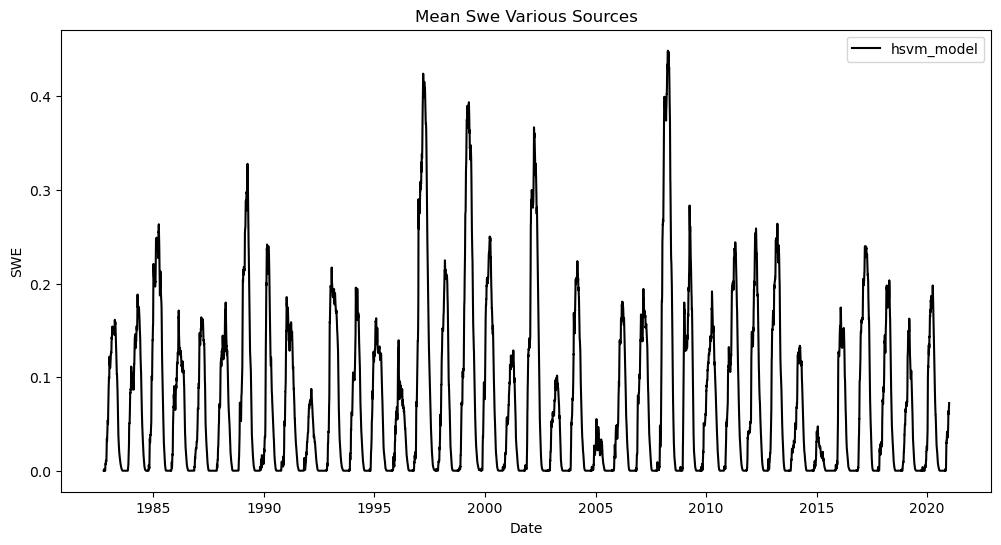

In [17]:
plot(x_vals, [HSVM_dict], ttl = "Mean Swe Various Sources")

In [18]:
# Step 3 - Load and Visualize UA SWE 

In [19]:
# get UA SWE directly from bronze 
geos_hsvm = load_shape(my_dict["hsvm_shape_key"])
df_UA_all = mean_swe_UA_from_shape(geos_hsvm) 
df_UA_all = filter_by_date(df_UA_all, BEGIN_DATE, END_DATE)
x_vals = df_UA_all.index.values
df_UA_all_dict = {
    "y_vals": df_UA_all["mean_swe"]/1000,
    "label": "UA_direct_from_shapefile",
    "color": "blue"
}


In [20]:
#geos_hsvm.explore()

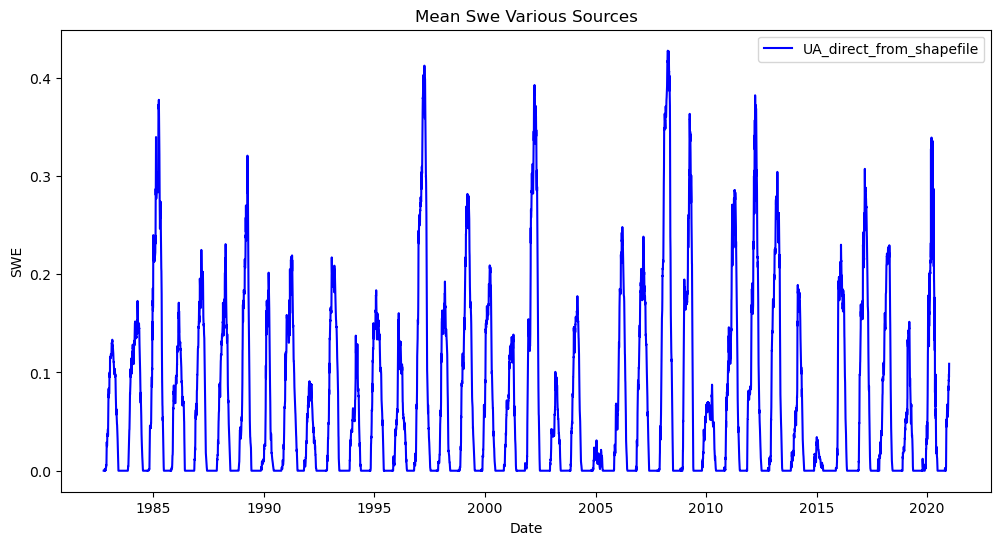

In [21]:
plot(x_vals, [df_UA_all_dict], ttl = "Mean Swe Various Sources")

In [22]:
# get UA mean Swe by aggregating over Hucs 
geos_hsvm_hucs = load_shape(my_dict["hsvm_huc_key"])
huc_list= geos_hsvm_hucs["huc_id"]
df_UA_from_hucs = mean_swe_from_hucs(huc_list)
df_UA_from_hucs = filter_by_date(df_UA_from_hucs, BEGIN_DATE, END_DATE)
df_UA_hucs_dict = {
    "y_vals": df_UA_from_hucs["mean_swe"]/1000,
    "label": "UA_calc_from_hucs",
    "color": "purple"
}


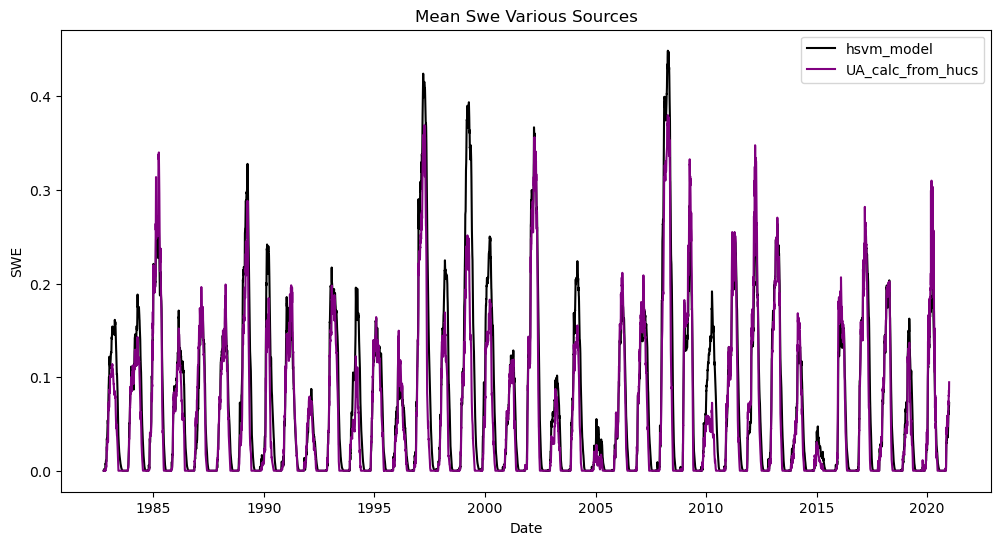

In [23]:
plot(x_vals, [HSVM_dict, df_UA_hucs_dict], ttl = "Mean Swe Various Sources")

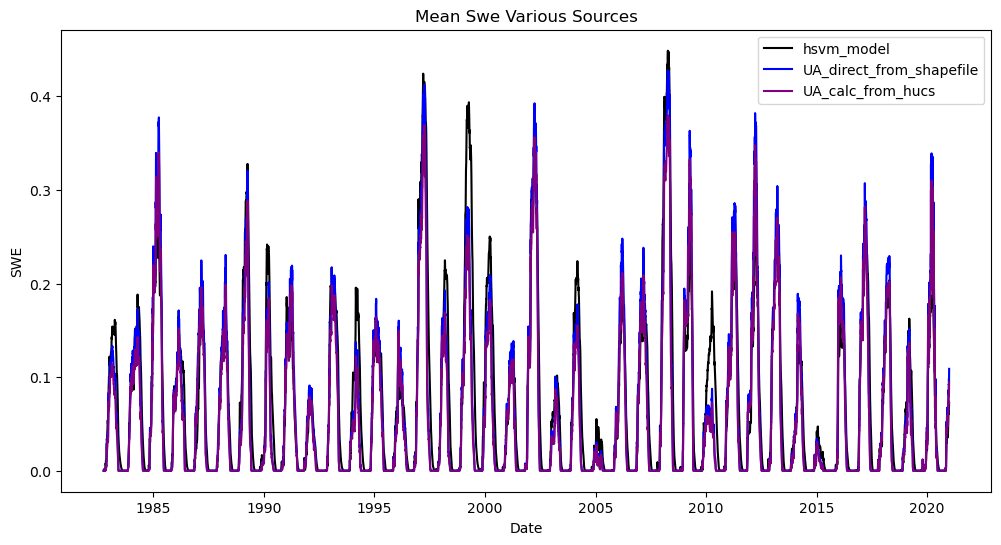

In [24]:
plot(x_vals, [HSVM_dict, df_UA_all_dict, df_UA_hucs_dict], ttl = "Mean Swe Various Sources")

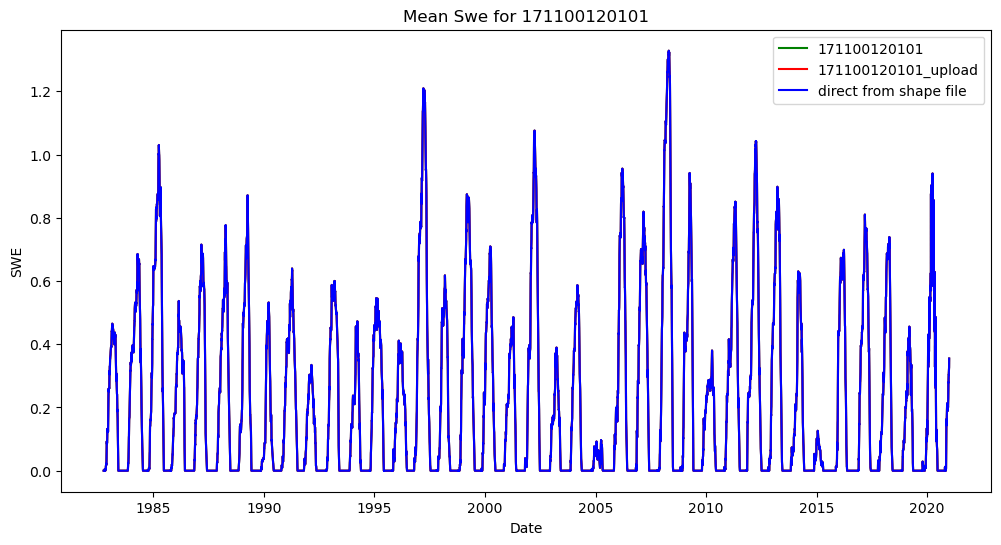

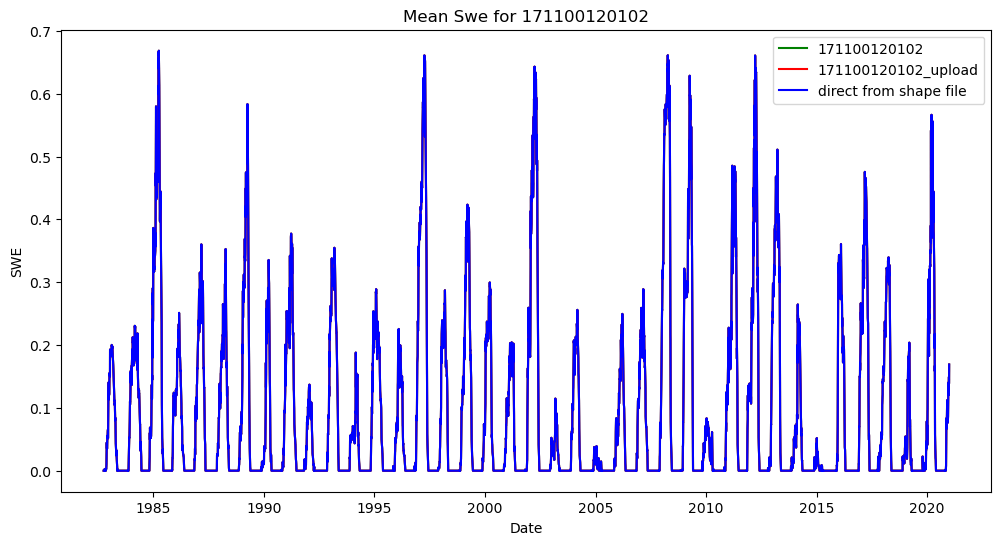

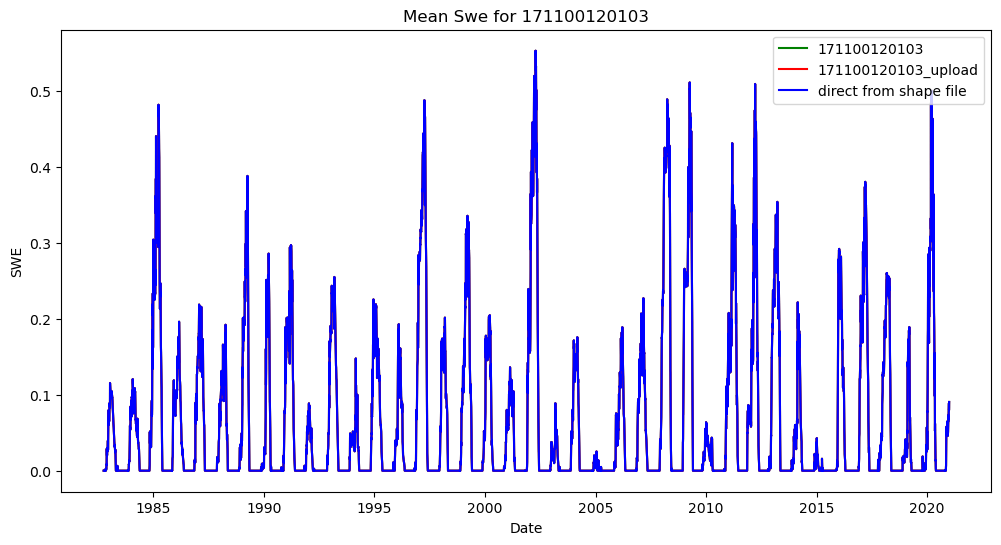

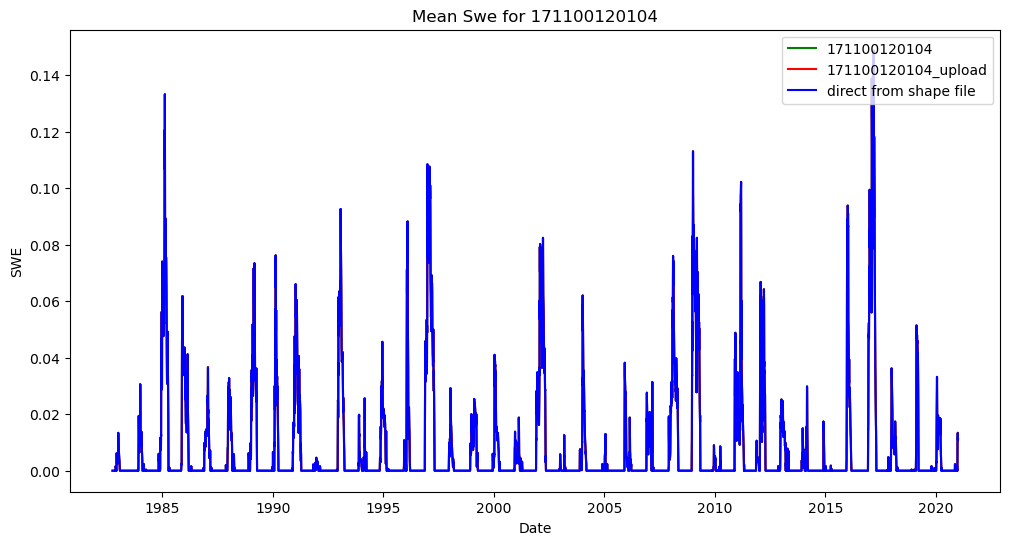

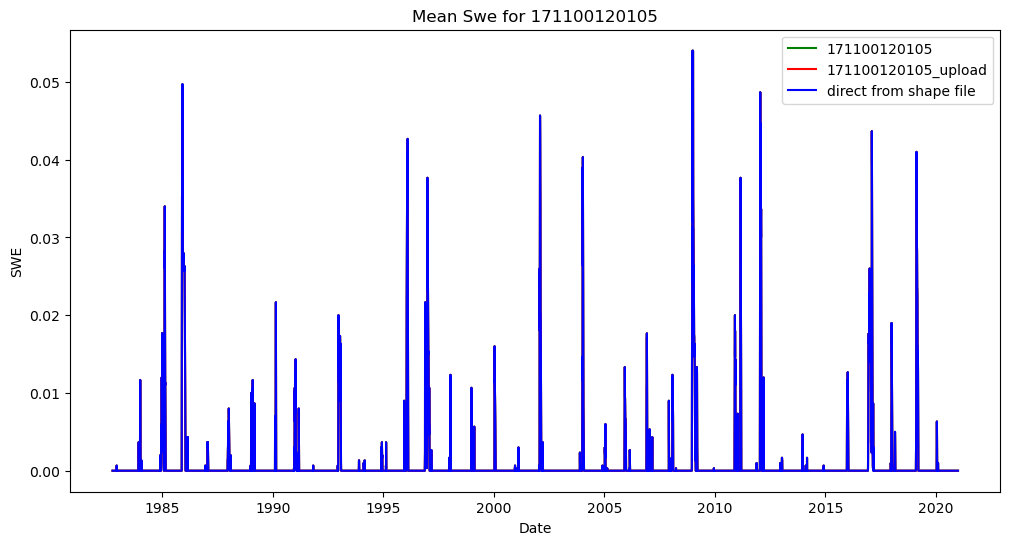

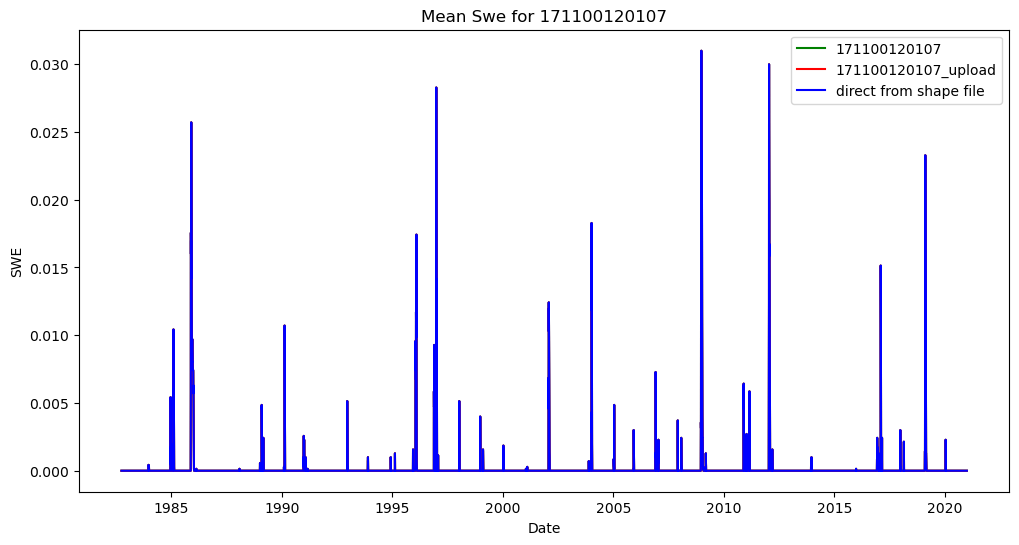

In [25]:
# plot mean Swe for each huc 
b = "snowml-gold"
for huc in huc_list: 
    df_huc, area = tot_swe_one_huc(huc)
    df_huc = filter_by_date(df_huc, BEGIN_DATE, END_DATE)
    x_vals = df_huc.index.values
    y_dict_calc = {
        "y_vals": df_huc["total_swe"]/(area*1000), 
        "color": "green",
        "label" : huc
        }
    f = f"mean_swe_in_{huc}.csv"
    df_huc2 = du.s3_to_df(f, b)
    df_huc2 = df_huc2.set_index("day")
    df_huc2 = filter_by_date(df_huc2, BEGIN_DATE, END_DATE)
    y_dict_upload = {
        "y_vals": df_huc2["mean_swe"]/1000, 
        "color": "red",
        "label": f"{huc}_upload"
    }  

    geos = gg.get_geos(huc, '12') 
    df_huc3 = mean_swe_UA_from_shape(geos)
    df_huc3 = filter_by_date(df_huc3, BEGIN_DATE, END_DATE)
    
    y_dict_shp = {
        "y_vals": df_huc3["mean_swe"]/1000,
        "color": "blue",
        "label": "direct from shape file"
    }

    
    plot(x_vals, [y_dict_calc, y_dict_upload, y_dict_shp], ttl = f"Mean Swe for {huc}")

In [26]:
huc_list

0    171100120101
1    171100120102
2    171100120103
3    171100120104
4    171100120105
5    171100120107
Name: huc_id, dtype: object